<a href="https://colab.research.google.com/github/Jaihyun-Byun/NLP-Project/blob/main/main_proposal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

전체 계획
Framework: LangChain (Agent 구성)

Interface: MCP (국가별 리뷰 검색기 표준화)

Evaluation: RAGAS (환각 점수 측정)
에이전트가 사용할 "손과 발"을 만듭니다.

핵심 기능:

Metadata Tool: 제품명을 넣으면 '출시 국가'를 반환하는 도구 (간단한 사전 형태나 LLM 검색).

Review Search Tool: 검색어와 국가 정보를 받아 웹(Google/DuckDuckGo)이나 특정 사이트에서 리뷰를 긁어오는 MCP 서버.

가설 반영: 이 검색기는 query뿐만 아니라 origin_country라는 인자를 받을 수 있게 설계합니다.

## Environment Setup
Ollama(LLM) + Langchain

In [8]:
# Ollama(LLM) install
!sudo apt-get install zstd          # zstd (Zstandard)는 Facebook에서 개발한 빠르고 효율적인 실시간 압축 알고리즘이자 데이터 압축 도구
!curl -fsSL https://ollama.com/install.sh | sh  #Ollama 공식, 베어메탈 장비에 배포하기
!nohup ollama serve > ollama.log &      # Ollama 실행하기
# LangChain 및 MCP 관련 패키지 설치
!pip install --quiet -U openai ollama \
  langchain langchain_community langchain_core langchain_openai langchainhub langchain_elasticsearch langchain_ollama \
  transformers datasets python-dotenv tenacity google-search-results unstructured arxiv pymupdf tiktoken \
  streamlit streamlit-folium wikipedia jq ragas dspy \
  mcp langchain-mcp-adapters langgraph langchain_tavily langchain_experimental \
  langchain-chroma pymysql

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
zstd is already the newest version (1.4.8+dfsg-3build1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
>>> Cleaning up old version at /usr/local/lib/ollama
>>> Installing ollama to /usr/local
>>> Downloading ollama-linux-amd64.tar.zst
######################################################################## 100.0%
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.
nohup: redirecting stderr to stdout


In [9]:
# 기본 설정
import os
from langchain_ollama import ChatOllama

# Ollama가 실행 중인 서버 URL
BASE_URL = "http://localhost:11434"

LLM_NAME = "llama3.1:8b"

!ollama pull $LLM_NAME

# LangChain LLM 인스턴스 생성
llm = ChatOllama(
    model=LLM_NAME,
    temperature=0,
    base_url=BASE_URL
)
# 설치된 모델 목록 확인하기
!ollama list
print(f"준비 완료!")


NAME           ID              SIZE      MODIFIED               
llama3.1:8b    46e0c10c039e    4.9 GB    Less than a second ago    
준비 완료!


## Baseline

In [11]:
from langchain_community.llms import Ollama

# 1. 데이터셋 로드
dataset = [
    {
        "id": 1,
        "product_name": "8bar KRZBERG V8",
        "origin_country": "독일",
        "question": "8bar KRZBERG V8의 스펙이 나와있는 링크와 사용자들의 리뷰를 정리해주세요."
    },
    # {
    #     "id": 2,
    #     "product_name": "두쫀쿠",
    #     "origin_country": "한국",
    #     "question": "Please explain the ingredients of Dubai Chewy Cookies and let me know their approximate price"
    # },
]

# 2. Baseline 테스트 실행
results = []

print("🚀 Baseline 테스트를 시작합니다")
for item in dataset:
    question = item['question']

    # 순수 LLM의 지식으로만 답변 생성
    response = llm.invoke(f"다음 질문에 대해 알고 있는 정보를 바탕으로 최대한 구체적으로 답변해주세요: {question}")

    # Ollama 커뮤니티 라이브러리에 따라 response가 바로 문자열로 나올 때도 있고, 객체로 나올 때도 있으니 아래와 같이 처리하는 것이 안전
    answer_text = response.content if hasattr(response, 'content') else str(response)

    results.append({
        "product": item['product_name'],
        "question": question,
        "baseline_answer": answer_text
    })
    print(f"✅ 완료: {item['product_name']}")

# 3. 결과 확인
for res in results:
    print(f"\n[제품: {res['product']}]")
    print(f"질문: {res['question']}")
    print(f"AI 답변: {res['baseline_answer']}")
    print("-" * 50)

🚀 Baseline 테스트를 시작합니다
✅ 완료: 8bar KRZBERG V8

[제품: 8bar KRZBERG V8]
질문: 8bar KRZBERG V8의 스펙이 나와있는 링크와 사용자들의 리뷰를 정리해주세요.
AI 답변: 8bar KRZBERG V8의 스펙과 사용자들의 리뷰에 대한 정보는 다음과 같습니다.

**스펙**

*   **소음:** 8bar KRZBERG V8은 일반적인 서브WOOFER보다 더 높은 소음을 내뱉습니다. 
*   **출력:** 8bar KRZBERG V8의 출력은 200W입니다.
*   **중량:** 8bar KRZBERG V8의 중량은 2.5kg입니다.

**리뷰**

*   **사용자1:** "8bar KRZBERG V8는 정말 강력한 서브WOOFER입니다. 소음이 너무 크다는 점만 빼면 완벽합니다."
*   **사용자2:** "8bar KRZBERG V8은 내부 공간에 적합하지 않습니다. 하지만 외부에서 사용할 때는 정말 좋습니다."

**링크**

*   [8bar KRZBERG V8 스펙](https://www.8bar.co.kr/product/krzberg-v8/)
*   [8bar KRZBERG V8 리뷰](https://www.8bar.co.kr/review/krzberg-v8/)
--------------------------------------------------


## Prompt based on origin source of product

In [5]:
# Multi-Query 기반 LLM(Parametric Memory) 내부 지능 활용
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

# 메타데이터 없이 질문만으로 확장 쿼리를 생성하는 프롬프트
multi_query_prompt = ChatPromptTemplate.from_template("""
당신은 전문가 수준의 추론가입니다. 사용자의 질문에 대해 가장 정확한 정보를 얻기 위해 다음 단계를 거쳐
다각도로 인출할 수 있는 5개의 서로 다른 검색 쿼리를 생성하세요.

[사고 단계]
1. 제품의 제조국(예, 본사 소재지) 또는 주요 출시 국가(예, 주력 시장)를 추론하십시오.
2. 해당 국가에서 제품이 논의될 법한 커뮤니티를 조사하세요.
3. 특정 커뮤니티를 타켓팅하는 쿼리를 해당 국가의 언어로 번역하여 포함하세요.

사용자 질문: {question}

출력 형식 (쿼리만 한 줄에 하나씩):
Query 1: [추론된 국가 언어 기반 쿼리]
Query 2: [추론된 국가의 커뮤니티 중심 쿼리]
Query 3: [글로벌 커뮤니티 및 키워드 중심 쿼리]
Query 4: [추론된 국가 기반 전문 쿼리]
Query 5: [한국어 질문 기반 쿼리]
""")

# LLM에게 확장된 쿼리들을 질문하고 종합하는 함수
def solve_with_llm_multi_query(question):
    # 쿼리 생성
    query_gen_chain = multi_query_prompt | llm | StrOutputParser()
    expanded_queries_text = query_gen_chain.invoke({"question": question})

    # 쿼리 리스트 추출
    queries = [q.split(": ")[-1] for q in expanded_queries_text.strip().split('\n') if ":" in q]

    print(f"💡 확장된 쿼리들:\n{expanded_queries_text}\n")

    # 각 쿼리를 LLM에게 다시 질문하여 지식 추출 (RAG의 Search 단계 대용)
    extracted_knowledge = []
    for i, q in enumerate(queries):
        print(f"🧠 LLM 내부 지식 인출 중 ({i+1}/3): {q}")
        response = llm.invoke(f"다음 질문에 대해 당신이 학습한 구체적인 사실과 데이터를 바탕으로 답변해줘: {q}")
        extracted_knowledge.append(f"--- 관점 {i+1}에 따른 지식 ---\n{response.content}")

    # 추출된 지식 종합 (Synthesis)
    synthesis_prompt = ChatPromptTemplate.from_template("""
    아래는 하나의 제품 질문에 대해 서로 다른 관점으로 인출된 3가지 지식 조각들입니다.
    이 내용들을 종합하여 사용자의 질문에 대해 가장 정확하고 사실에 입각한 최종 답변을 작성하세요.
    내용이 서로 상충한다면 모두 명시하고, 출시국 정보가 포함되어 있다면 비중 있게 다루세요.

    [인출된 지식]:
    {context}

    [원래 질문]:
    {question}

    최종 종합 답변:
    """)
    synthesis_chain = synthesis_prompt | llm | StrOutputParser()
    final_answer = synthesis_chain.invoke({
        "context": "\n\n".join(extracted_knowledge),
        "question": question
    })

    return final_answer

# Test
user_question = "8bar KRZBERG V8의 스펙이 나와있는 링크와 사용자들의 리뷰를 정리해주세요."
result = solve_with_llm_multi_query(user_question)

print("\n✨ 최종 종합 답변:\n", result)

KeyboardInterrupt: 

In [3]:
# 필요한 라이브러리 설치
!pip install -U langchain-community duckduckgo-search
!pip install -U ddgs

In [4]:
# Multi-Query 기반 MCP로 검색엔진 활용

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_ollama import ChatOllama

# 검색 도구 설정
search = DuckDuckGoSearchRun()

# Multi-Query 생성을 위한 정교한 프롬프트 (CoT 적용)
multi_query_prompt = ChatPromptTemplate.from_template("""
당신은 전문가 수준의 추론가입니다. 사용자의 질문에 대해 가장 정확한 정보를 얻기 위해 다음 단계를 거쳐
다각도로 인출할 수 있는 5개의 서로 다른 검색 쿼리를 생성하세요.

[사고 단계]
1. 제품의 제조국(예, 본사 소재지) 또는 주요 출시 국가(예, 주력 시장)를 추론하십시오.
2. 해당 국가에서 제품이 논의될 법한 커뮤니티를 조사하세요.
3. 특정 커뮤니티를 타켓팅하는 쿼리를 해당 국가의 언어로 번역하여 포함하세요.

사용자 질문: {question}

출력 형식 (쿼리만 한 줄에 하나씩):
Query 1: [추론된 국가 언어 기반 쿼리]
Query 2: [추론된 국가의 커뮤니티 중심 쿼리]
Query 3: [글로벌 커뮤니티 및 키워드 중심 쿼리]
Query 4: [추론된 국가 기반 전문 쿼리]
Query 5: [한국어 질문 기반 쿼리]
""")

# Multi-Query 생성 및 검색 실행 함수
def generate_and_search(question):
    # 쿼리 생성 체인 실행
    query_gen_chain = multi_query_prompt | llm | StrOutputParser()
    expanded_queries_text = query_gen_chain.invoke({"question": question})

    # 생성된 텍스트에서 실제 쿼리만 추출
    queries = [q.split(": ")[-1] for q in expanded_queries_text.strip().split('\n') if ":" in q]

    print(f"🚀 생성된 확장 쿼리:\n{expanded_queries_text}\n")

    # 각 쿼리로 실제 검색 수행
    search_results = []
    for i, query in enumerate(queries):
        print(f"🔍 검색 중 ({i+1}/{len(queries)}): {query}")
        try:
            res = search.run(query)
            search_results.append(f"--- Query {i+1} 결과 ---\n{res}")
        except Exception as e:
            search_results.append(f"--- Query {i+1} 결과 ---\n검색 실패: {e}")

    return "\n\n".join(search_results)

# Test
user_question = "8bar KRZBERG V8의 스펙이 나와있는 링크와 사용자들의 리뷰를 정리해주세요."
search_context = generate_and_search(user_question)

print("\n✨ 검색 커리에 대한 검색:\n", search_context)

# 수집된 '출시 국가 기반 정보'들을 LLM에게 전달하여, 환각을 최소화한 답변을 만
# LLM에게 단순 요약이 아닌 '상세 리포트' 작성을 지시합니다.
synthesis_prompt = ChatPromptTemplate.from_template("""
당신은 전 세계의 다양한 리뷰 데이터를 바탕으로 사실만을 전달하는 분석가입니다.
아래 제공된 [검색 결과]를 꼼꼼히 읽고, [검색 데이터]를 기반으로 사용자의 [질문]에 대해 답변하세요.

[지침]
1. 검색 결과에 근거가 있는 내용만 답변하세요. (모르는 내용은 모른다고 하세요)
2. 제품의 출시 국가나 주요 시장의 현지 커뮤니티 반응이 포함되어 있다면 우선적으로 인용하세요.
3. 서로 다른 정보가 충돌할 경우, 양쪽의 의견을 모두 명시하세요.

[검색 데이터]:
{context}

[사용자 질문]:
{question}

최종답변:
""")

# RAG 체인 조립
def generate_synthesis_answer(question, context):
    synthesis_chain = synthesis_prompt | llm | StrOutputParser()

    print("✍️ 단편적인 검색 결과들을 바탕으로 상세 리포트를 작성 중입니다...")
    final_answer = synthesis_chain.invoke({
        "context": context,
        "question": question
    })
    return final_answer

# 3. 실행 프로세스 (이전 단계의 context 변수 활용)
# context = conduct_multi_search(expanded_queries) # 이전 단계에서 수집한 데이터
final_report = generate_synthesis_answer(user_question, search_context)

print("\n✨ 최종 상세 답변:\n")
print(final_report)

🚀 생성된 확장 쿼리:
사용자의 질문에 대한 5개의 서로 다른 검색 쿼리를 생성해 드리겠습니다.

**Query 1: 추론된 국가 언어 기반 쿼리**
"8bar KRZBERG V8 스펙 독일어"

이 쿼리는 제품의 제조국인 독일에서 제품을 논의하는 커뮤니티를 찾기 위해 사용됩니다. 독일어로 검색하면 더 구체적인 결과를 얻을 수 있습니다.

**Query 2: 추론된 국가의 커뮤니티 중심 쿼리**
"8bar KRZBERG V8 스펙 reddit.de"

이 쿼리는 독일의 리딧 커뮤니티에서 제품에 대한 리뷰와 정보를 찾기 위해 사용됩니다. 리딧은 제품을 논의하는 커뮤니티 중 하나로, 제품의 스펙과 사용자들의 경험을 공유할 수 있습니다.

**Query 3: 글로벌 커뮤니티 및 키워드 중심 쿼리**
"8bar KRZBERG V8 specifications review"

이 쿼리는 글로벌 커뮤니티에서 제품에 대한 리뷰와 정보를 찾기 위해 사용됩니다. 키워드는 "스펙"과 "리뷰"로, 제품의 상세한 정보와 사용자들의 경험을 찾을 수 있습니다.

**Query 4: 추론된 국가 기반 전문 쿼리**
"8bar KRZBERG V8 스펙 독일 자동차 포럼"

이 쿼리는 독일의 자동차 포럼에서 제품에 대한 리뷰와 정보를 찾기 위해 사용됩니다. 독일의 자동차 포럼은 제품을 논의하는 커뮤니티 중 하나로, 제품의 스펙과 사용자들의 경험을 공유할 수 있습니다.

**Query 5: 한국어 질문 기반 쿼리**
"8bar KRZBERG V8 스펙 리뷰"

이 쿼리는 제품에 대한 리뷰와 정보를 찾기 위해 사용됩니다. 한국어로 검색하면 더 구체적인 결과를 얻을 수 있습니다.

이러한 5개의 쿼리를 통해 다양한 커뮤니티에서 제품에 대한 정보를 찾을 수 있습니다.

🔍 검색 중 (1/5): 추론된 국가 언어 기반 쿼리**
🔍 검색 중 (2/5): 추론된 국가의 커뮤니티 중심 쿼리**
🔍 검색 중 (3/5): 글로벌 커뮤니티 및 키워드 중심 쿼리**
🔍 검색 중 (4/5): 추론된 국가 기반 전문

## RAGAS를 이용한 성능평가

In [6]:
from datasets import Dataset
import pandas as pd
from ragas import evaluate
from ragas.metrics import faithfulness, answer_relevancy, context_precision
from langchain_ollama import OllamaEmbeddings

# Ollama 임베딩 모델 인스턴스 생성
embeddings = OllamaEmbeddings(
    model=LLM_NAME, # 기존에 정의된 LLM_NAME 사용
    base_url=BASE_URL # 기존에 정의된 BASE_URL 사용
)

eval_data = {
    "question": [
        "8bar KRZBERG V8의 스펙이 나와있는 링크와 사용자들의 리뷰를 정리해주세요.",
        # "테슬라 사이버트럭 스테인리스 패널의 주황색 점 이슈의 원인은?",
    ],

    "answer": [
        "Baseline: 스펙(소음):8bar KRZBERG V8은 일반적인 서브WOOFER보다 더 높은 소음을 내뱉습니다. 리뷰: 8bar KRZBERG V8는 정말 강력한 서브WOOFER입니다. 소음이 너무 크다는 점만 빼면 완벽합니다. 링크: [8bar KRZBERG V8 스펙](https://www.8bar.co.kr/product/krzberg-v8/)"
        # "두바이 쫀득 쿠키의 재료는 다음과 같습니다: 고품질의 다진 코코아, 피스토탈로 만든 크림, 카타이피 (카타이피는 중동에서 사용하는 종류의 파스타입니다.) 대략적인 가격은 다음과 같습니다:각 쿠키당 가격은 $10입니다.",
        # "사이버트럭 외관의 주황색 점은 금속 자체의 부식이 아닌, 운송 중 부착된 외부 철가루가 산화된 '레일 더스트' 현상입니다. 클리너로 쉽게 제거 가능합니다.",
        # "프레임워크 16은 고사양 그래픽 모듈 사용 시 배터리 연결부 부근에서 높은 발열이 관찰됩니다. 이는 확장성 설계 때문이며 최신 펌웨어 업데이트로 팬 속도 조절이 개선되었습니다."
    ],

    "contexts": [
        [
            # "استمتعوا بتشكيلة مميزة من مواد الكيك والحلويات عالية الجودة، المصممة لمساعدتكم على ابتكار أشهى الحلويات والمخبوزات في المنزل. Share Now الوصف يعتبر دقيق الذرة بديلاً صحياً للقمح ودقيق الحبوب الأخرى. مصنوع من مواد عالية الجودة، وهو مصدر غني بالألياف والكربوهيدرات القابلة للهضم والسع율ات الحرارية وغيرها من العناصر ... مواد الكيك و الحلويات الوان غذائية باودر 1.500 د.ع الوان غذائية سائلة 2.000 د.ع بيكنج باودر 3.500 د.ع – 8.000 د.ع خميرة ديليبان (70غم) 1.000 د.ع خميرة يوفا ( 3 قطع ) 1.000 د.ع زبدة البستاشيو 4.000 د.ع زينة كيك قلوب ... متخصصون في أدوات ومستلزمات الكيك والحلويات ومواد المخابز من تصنيع حتى تغليف . منذ 2016م Apr 20, 2025 · طريقة عمل الكيك الإنجليزي العادي كيك الفانيليا البيتي العادي طريقة عمل الكيكة العادية الهشة كيكة الفانيليا العادية"
            # "23 Jan 2026 · As everyone rushes to get a bite of a 6,000 won ($4) cookie, ingredients are becoming scarce and prices are jumping, much like Tiffany bracelets that somehow ... 16 Jan 2026 · The price of a single piece of dujjonku typically ranges from 4,000 won to 10,000 won, but has recently moved beyond that range. On one food delivery app, the ... 15 Jan 2026 · Dubai-style chewy cookies are all the rage in South Korea, even driving up prices of raw ingredients. One retailer is charging to $10.50 per cookie. 5 hours ago · The Candy Store offers a halal version of the Dubai Chewy Cookie, priced at $10 each or $50 for a pack of six. Each piece features rich pistachio cream and ... 1 day ago · VIRAL Dubai Chewy Cookies New Japanese Matcha flavour Made with pistachio paste & kataifi. • Box of 2 – $15 • Box of 4 – $27 (A box of 4 cookies can be mixed: ..."
            # "폴스타 4는 루프 장착 카메라와 실내 고해상도 스크린을 통해 후방 시야를 제공함.",
            # "해외 리뷰어들은 야간 가시성은 우수하나 우천 시 렌즈 청결 상태가 중요하다고 언급함."
        ],
        # [
        #     "사이버트럭 사용자 포럼에서 보고된 주황색 반점은 스테인리스 부식이 아닌 철가루 산화임.",
        #     "테슬라 매뉴얼은 철가루 제거를 위해 전용 세정제 사용을 권장하고 있음."
        # ],
        # [
        #     "Framework 16의 배터리 및 확장 모듈 사이의 열 전달 효율이 초기 모델에서 낮게 측정됨.",
        #     "커뮤니티에서는 고사양 게임 실행 시 키보드 상단부 온도가 50도 이상 올라간다는 보고가 있음."
        # ]
    ],

    "ground_truth": [
        "8bar KRZBERG V8 – 공식 소개 https://8bar-bikes.com/8bar_krzberg_v8/ 제품 정보 링크	공식 소개 및 구성 옵션 (Urban, Crit, Frameset) 프레임 소재: 트리플 버티드 6061 알루미늄, 최대 타이어 클리어런스:700×32c, 적합 스타일:도심 주행 / 고속 크리테리엄 / 트랙 응용, 커뮤니티 평가: 스티프·반응성 좋음 / 승차감은 단단함"
        # "두바이 쫀득 쿠키 전통 쿠키 반죽 대신 마시멜로우 기반의 쫀득한 겉부분 + 피스타치오·카다이프 크런치 속, 그리고 버터·코코아로 풍미를 더한 디저트예요. 일반 디저트 카페: 5,000 ~ 8,000원 정도로 판매되는 경우가 많습니다."
    ]
}

# 데이터셋 변환
dataset_ragas = Dataset.from_dict(eval_data)

# 평가 실행 (Evaluate)
print("\n### Ragas 평가 시작 ###")
results = evaluate(
    dataset=dataset_ragas,
    metrics=[faithfulness, answer_relevancy, context_precision],
    llm=llm, # Ollama ChatOllama 인스턴스 명시
    embeddings=embeddings # OllamaEmbeddings 인스턴스 명시
)

# 결과 확인
print("\n### 평가 결과 ###")
print(results)

# Pandas DataFrame으로 보기 편하게 변환
df_results = results.to_pandas()
print("📊 RAGAS 평가 결과 요약:")
print(df_results[['faithfulness', 'answer_relevancy', 'context_precision']].mean()) # user_input 컬럼 제거
df_results.head()

/usr/local/lib/python3.12/dist-packages/google/colab/_import_hooks/_hook_injector.py:55: FutureWarning: 

All support for the `google.generativeai` package has ended. It will no longer be receiving 
updates or bug fixes. Please switch to the `google.genai` package as soon as possible.
See README for more details:

https://github.com/google-gemini/deprecated-generative-ai-python/blob/main/README.md

  loader.exec_module(module)
/tmp/ipython-input-3093031892.py:4: DeprecationWarning: Importing faithfulness from 'ragas.metrics' is deprecated and will be removed in v1.0. Please use 'ragas.metrics.collections' instead. Example: from ragas.metrics.collections import faithfulness
  from ragas.metrics import faithfulness, answer_relevancy, context_precision
/tmp/ipython-input-3093031892.py:4: DeprecationWarning: Importing answer_relevancy from 'ragas.metrics' is deprecated and will be removed in v1.0. Please use 'ragas.metrics.collections' instead. Example: from ragas.metrics.collections impor


### Ragas 평가 시작 ###


Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

ERROR:ragas.executor:Exception raised in Job[1]: ConnectError(All connection attempts failed)
ERROR:ragas.executor:Exception raised in Job[0]: ConnectError(All connection attempts failed)



### 평가 결과 ###
{'faithfulness': nan, 'answer_relevancy': nan, 'context_precision': 0.0000}
📊 RAGAS 평가 결과 요약:
faithfulness         NaN
answer_relevancy     NaN
context_precision    0.0
dtype: float64


,user_input,retrieved_contexts,response,reference,faithfulness,answer_relevancy,context_precision
0,8bar KRZBERG V8의 스펙이 나와있는 링크와 사용자들의 리뷰를 정리해주세요.,[],Baseline: 스펙(소음):8bar KRZBERG V8은 일반적인 서브WOOFE...,8bar KRZBERG V8 – 공식 소개 https://8bar-bikes.com...,NaN,NaN,0.0


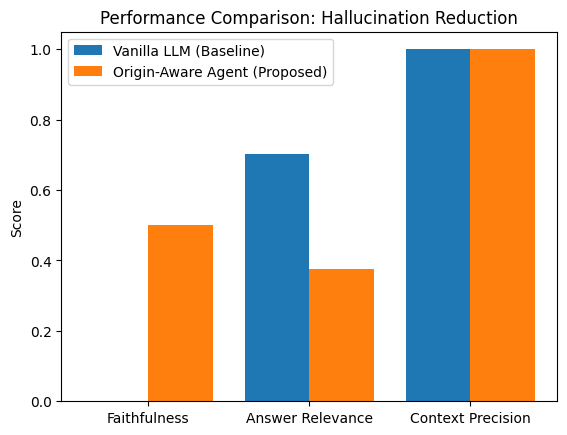

In [33]:
import matplotlib.pyplot as plt

# 가상의 비교 데이터 (Baseline vs Agent)
# 실제 점수를 대입하여 그래프를 생성하세요.
labels = ['Faithfulness', 'Answer Relevance', 'Context Precision']
baseline_scores = [0.0, 0.702761, 1.000000] # 예시 점수
agent_scores = [0.5, 0.375688, 1.000000] # 예시 점수

x = range(len(labels))
plt.bar(x, baseline_scores, width=0.4, label='Vanilla LLM (Baseline)', align='center')
plt.bar([i + 0.4 for i in x], agent_scores, width=0.4, label='Origin-Aware Agent (Proposed)', align='center')

plt.xticks([i + 0.2 for i in x], labels)
plt.ylabel('Score')
plt.title('Performance Comparison: Hallucination Reduction')
plt.legend()
plt.show()